# Security Investments (ROSI)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data preparation

In [2]:
# data source: https://surfdrive.surf.nl/files/index.php/s/CZWfWQp3VKGKa8m
df = pd.read_csv('../data_with_ports.csv.gz', sep='|', compression='gzip')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (15,17,19,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# parse string to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['start_time'] = pd.to_datetime(df['start_time'], format='%Y-%m-%dT%H:%M:%S+09:00')
df['stop_time'] = pd.to_datetime(df['stop_time'], format='%Y-%m-%dT%H:%M:%S+09:00')

In [4]:
# subset hosting providers only
dfASesHosting = df.loc[df["as_type"] == "hosting"]
#dfASesHosting.info() # premilary inspection

# drop columns with all null values
dfASesHosting.drop(columns=["tg_op", "subs"], inplace=True)

# fix null values in `region`
dfASesHosting[dfASesHosting.region.isna()][["cc", "region"]].drop_duplicates() # found US and CA have region = NaN
dfASesHosting.region.fillna("NA", inplace=True) # NA = North America

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [5]:
dfASesHosting.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 473792 entries, 2948 to 5697809
Data columns (total 33 columns):
target_ip                 473792 non-null object
date                      473792 non-null datetime64[ns]
sensor_id                 473792 non-null object
service                   473792 non-null object
start_time                473792 non-null datetime64[ns]
stop_time                 473792 non-null datetime64[ns]
duration                  473792 non-null float64
packets                   473792 non-null int64
raw_country               473792 non-null object
raw_as                    473792 non-null object
raw_hostname              473792 non-null object
udp_port_list             473792 non-null object
pyasn_as                  473792 non-null float64
pyasn_as_bgp_size         472991 non-null float64
cc                        473792 non-null object
region                    473792 non-null object
is_oecd                   473792 non-null float64
as_type                  

In [6]:
from random import randint

dfASesHosting.iloc[randint(0, len(dfASesHosting))]

target_ip                                                        5.39.13.70
date                                                    2015-12-21 00:00:00
sensor_id                                                         sensor002
service                                                                 dns
start_time                                              2015-12-21 11:22:13
stop_time                                               2015-12-21 11:39:03
duration                                                               1010
packets                                                                3171
raw_country                                                          France
raw_as                                                      AS16276 OVH SAS
raw_hostname                                             ip70.ip-5-39-13.eu
udp_port_list                                              [160481, 194956]
pyasn_as                                                              16276
pyasn_as_bgp

## Metadata

Decsriptions of the metadata (Cheung, 2017):

| Column | Description |
| ------ | ----------- |
| `target_ip` | The IP address that has been targeted by a DDoS attackc |
| `date` | The date of attack |
| `sensor_id` | The name of the honeypot that monitored the attack traffic |
| `service` | The protocol that was used to execute the attack |
| `start_time` | The start time of the attack |
| `stop_time` | The stop time of the attack |
| `duration` | Attack duration |
| `pyasn_as` | The autonomous system number identifying which AS is routing traffic for the attacked IP |
| `pyasn_as_bpg_size` | The total number of IP addresses that the AS routes |
| `cc` | Short form of the country where the IP address seems to reside |
| `as_type` | The type of the Autonomous system (could be ISP, Hosting, EDU, etc.) |
| `tg_op` | A string identifier to ASes that are known to be Broadband ISPs |
| `caida_type` | A type identifier for ASes based on different source (CAIDA) |
| `dc` | The number of second level domains that have been observed to map to the attacked IP addresses in DNS traffic |
| `subs` | The number of subscribers for those ASes that are known to be Broadband ISPs |
| `as_ipsize_seen` | The total number of IP addresses of the AS that have been observed to be routed to IPs of the AS in DNS traffic |
| `as_domainsize_seen` | The total number of second level domains that have been observed to be routed to IPs of the AS in DNS traffic |
| `year` | The year of the attack |
| `udp_port_list` | The ports that attack packets have been sent to |


## Hosting providers

In [9]:
def secondLevelDomainName(raw_hostname):
    '''get second-level domain name'''
    if raw_hostname.count(".") >= 2:
        d3, d2, d1 = raw_hostname.rsplit(".", 2)
        if (d2 == "com") | (d2 == "co"): # e.g. "co.uk" or "com.br" 
            return raw_hostname
        else:
            return d2 + "." + d1
    else:
        return raw_hostname

In [10]:
hostingDomains = dfASesHosting[~dfASesHosting.raw_hostname.isna()]
hostingDomains = hostingDomains[hostingDomains.raw_hostname != "None"]
hostingDomains['hostname'] = hostingDomains.raw_hostname.apply(secondLevelDomainName)
hostingDomains.head()

,target_ip,date,sensor_id,service,start_time,stop_time,duration,packets,raw_country,raw_as,...,org_ipsize_seen_shared,org_is_hosting,org_tag,caida_type,dc,as_ipsize_seen,as_domainsize_seen,pps,year,hostname
2948,100.42.49.140,2014-12-25,sensor003,ssdp,2014-12-25 13:47:59,2014-12-25 14:07:44,1185.0,441,United States,AS36351 SoftLayer Technologies Inc.,...,4944.0,1.0,hosting,Content,1982,542087.0,3384037.0,0.372152,2014,arvixe.com
2949,100.42.49.140,2014-12-25,sensor005,ssdp,2014-12-25 13:47:51,2014-12-25 14:07:49,1198.0,433,United States,AS36351 SoftLayer Technologies Inc.,...,4944.0,1.0,hosting,Content,1982,542087.0,3384037.0,0.361436,2014,arvixe.com
2950,100.42.49.140,2014-12-25,sensor007,ssdp,2014-12-25 13:47:50,2014-12-25 14:07:46,1196.0,440,United States,AS36351 SoftLayer Technologies Inc.,...,4944.0,1.0,hosting,Content,1982,542087.0,3384037.0,0.367893,2014,arvixe.com
2951,100.42.52.96,2014-12-23,sensor001,dns,2014-12-23 17:33:13,2014-12-23 17:48:00,887.0,491,United States,AS36351 SoftLayer Technologies Inc.,...,4944.0,1.0,hosting,Content,628,542087.0,3384037.0,0.553551,2014,mysitehosted.com
2952,100.42.57.238,2014-12-20,sensor001,ntp,2014-12-20 13:48:46,2014-12-20 13:50:47,121.0,2927,United States,AS21788 Network Operations Center Inc.,...,4944.0,1.0,hosting,Content,2,542087.0,3384037.0,24.190083,2014,mysitehosted.com


In [13]:
# top ten hosting providers under most attacks
mostAttackedHostingProviders = hostingDomains.hostname.value_counts()[:10]
mostAttackedHostingProviders

amazonaws.com            16469
your-server.de           15856
poneytelecom.eu          13582
lstn.net                  7391
softlayer.com             6454
alojandoargentina.net     5366
ovh.net                   4535
kimsufi.com               3416
as15003.net               2070
beastnode.com             2016
Name: hostname, dtype: int64

In [14]:
# as_ipsize_seen

hostingDomains_IpSizeSeen = {
    host : hostingDomains.loc[hostingDomains.hostname == host]
                         .as_ipsize_seen
                         .value_counts()
                         .reset_index()
    for host in mostAttackedHostingProviders.index
}

# weighted domain size

hostingDomains_IpSizeSeenWeighted = {
    host: (d["index"] * d["as_ipsize_seen"]).sum() / d["as_ipsize_seen"].sum()
    for (host, d) in hostingDomains_IpSizeSeen.items()
}

hostingDomains_IpSizeSeenWeighted = pd.DataFrame.from_dict(hostingDomains_IpSizeSeenWeighted, 
                                                           orient="index", columns=["ipsize_seen_weighted"])
hostingDomains_IpSizeSeenWeighted

,ipsize_seen_weighted
amazonaws.com,781597.918574
your-server.de,391410.000000
poneytelecom.eu,84462.000000
lstn.net,26579.000000
softlayer.com,542016.094360
alojandoargentina.net,12935.060380
ovh.net,599916.000000
kimsufi.com,599916.000000
as15003.net,506145.000000
beastnode.com,88208.625000


In [15]:
# as_domainsize_seen

hostingDomains_DomainSizeSeen = {
    host : hostingDomains.loc[hostingDomains.hostname == host]
                         .as_domainsize_seen
                         .value_counts()
                         .reset_index()
    for host in mostAttackedHostingProviders.index
}

# weighted domain size

hostingDomains_DomainSizeSeenWeighted = {
    host: (d["index"] * d["as_domainsize_seen"]).sum() / d["as_domainsize_seen"].sum()
    for (host, d) in hostingDomains_DomainSizeSeen.items()
}

hostingDomains_DomainSizeSeenWeighted = pd.DataFrame.from_dict(hostingDomains_DomainSizeSeenWeighted, 
                                                               orient="index", columns=["domainsize_seen_weighted"])
hostingDomains_DomainSizeSeenWeighted

,domainsize_seen_weighted
amazonaws.com,4.080514e+06
your-server.de,4.552561e+06
poneytelecom.eu,5.121730e+05
lstn.net,4.238320e+05
softlayer.com,3.383592e+06
alojandoargentina.net,1.092719e+05
ovh.net,5.984318e+06
kimsufi.com,5.984318e+06
as15003.net,1.170958e+06
beastnode.com,1.057769e+06


In [16]:
hostingDomainsMostAttacked = hostingDomains[hostingDomains.hostname.isin(mostAttackedHostingProviders.index.tolist())]
hostingDomainsMostAttacked.sort_values(by="hostname")
hostingDomainsMostAttacked[["hostname", "pps"]].sample(5)

,hostname,pps
173839,softlayer.com,0.567423
5404216,kimsufi.com,31.665000
4013375,your-server.de,43.585714
2110673,your-server.de,10.710000
605018,amazonaws.com,0.279832


In [17]:
idSortByMostAttacks = pd.DataFrame(mostAttackedHostingProviders.index, 
                                   columns=["hostname"]).reset_index()
hostingDomainsMostAttacked = (hostingDomainsMostAttacked.merge(idSortByMostAttacks, how="left", 
                                                               left_on="hostname", right_on="hostname")
                                                        .sort_values(by="index", ascending=False))
hostingDomainsMostAttacked[["hostname", "pps"]].head()

,hostname,pps
77154,beastnode.com,5.176471
42993,beastnode.com,5.972650
42999,beastnode.com,3.501967
42998,beastnode.com,3.444444
42997,beastnode.com,0.768537


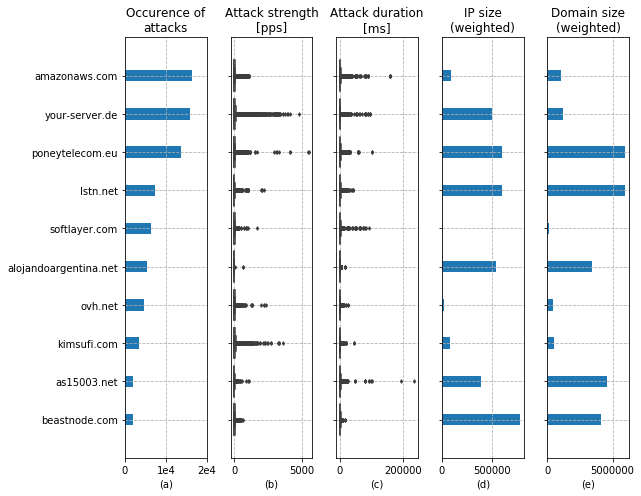

In [18]:
fig, ax = plt.subplots(1, 5, figsize=(9, 7), sharey=True)

sns.boxplot(data=hostingDomainsMostAttacked, x="pps", y="hostname", orient="h", 
            fliersize=2.5, ax=ax[1])
ax[1].set_ylabel("")
ax[1].set_xlabel("(b)")
ax[1].set_title("Attack strength\n[pps]")

sns.boxplot(data=hostingDomainsMostAttacked, x="duration", y="hostname", orient="h", 
            fliersize=2.5, ax=ax[2])
ax[2].set_ylabel("")
ax[2].set_xlabel("(c)")
ax[2].set_title("Attack duration\n[ms]")

ax[0].barh(mostAttackedHostingProviders.index, mostAttackedHostingProviders.values, height=0.3)
ax[0].set_title("Occurence of\nattacks")
ax[0].set_xlabel("(a)")
ax[0].set_xlim([0, 20000])
ax[0].set_xticklabels(["0", "1e4", "2e4"])

ax[3].barh(hostingDomains_IpSizeSeenWeighted.index,
           hostingDomains_IpSizeSeenWeighted.ipsize_seen_weighted, height=0.3)
ax[3].set_title("IP size\n(weighted)")
ax[3].set_xlabel("(d)")

ax[4].barh(hostingDomains_DomainSizeSeenWeighted.index,
           hostingDomains_DomainSizeSeenWeighted.domainsize_seen_weighted, height=0.3)
ax[4].set_title("Domain size\n(weighted)")
ax[4].set_xlabel("(e)")

ax[0].invert_yaxis()
ax[0].grid(linestyle='--')
ax[1].grid(linestyle='--')
ax[2].grid(linestyle='--')
ax[3].grid(linestyle='--')
ax[4].grid(linestyle='--')

plt.tight_layout()
fig.savefig("images/top-ten-host-providers.png")

## Misc

In [59]:
# fix null values in `org`

dfASesHosting[dfASesHosting.org.isna()][["raw_hostname", "raw_as", "org"]].drop_duplicates()

,raw_hostname,raw_as,org
2366054,None,AS33182 HostDime.com<comma> Inc.,NaN
2366066,None,AS36351 SoftLayer Technologies Inc.,NaN
2384332,172.81.110.132.static.klayer.com,AS36351 SoftLayer Technologies Inc.,NaN
2384338,172.81.110.140.static.klayer.com,AS36351 SoftLayer Technologies Inc.,NaN
2384340,172.81.110.27.static.klayer.com,AS36351 SoftLayer Technologies Inc.,NaN
2384343,172.81.110.79.static.klayer.com,AS36351 SoftLayer Technologies Inc.,NaN
2384347,172.81.110.90.static.klayer.com,AS36351 SoftLayer Technologies Inc.,NaN
2387411,None,None,NaN
2387772,None,AS27357 Rackspace Hosting,NaN
2819073,extreme.fastwebhosting.nl,AS48635 PCextreme B.V.,NaN


In [41]:
dfASesHosting[dfASesHosting.raw_as.str.contains("SoftLayer")].raw_as.unique()


array(['AS36351 SoftLayer Technologies Inc.',
       'AS21844 SoftLayer Technologies Inc.'], dtype=object)

In [62]:
dfASesHosting[dfASesHosting.raw_as.str.contains("Amazon")][["raw_as", "org", "caida_type"]].drop_duplicates()

,raw_as,org,caida_type
26826,AS14618 Amazon.com<comma> Inc.,Amazon.com,Content
204968,AS16509 Amazon.com<comma> Inc.,Amazon.com,Enterpise
204975,AS16509 Amazon.com<comma> Inc.,CloudFront DUB,Enterpise
204984,AS16509 Amazon.com<comma> Inc.,DUB8 EC,Enterpise
204986,AS16509 Amazon.com<comma> Inc.,DUB5 EC,Enterpise
204987,AS16509 Amazon.com<comma> Inc.,DUB6 EC,Enterpise
559408,AS16509 Amazon.com<comma> Inc.,"Amazon Web Services, Elastic Compute Cloud, EC...",Enterpise
602840,AS14618 Amazon.com<comma> Inc.,Amazon,Content
603059,AS16509 Amazon.com<comma> Inc.,Amazon,Enterpise
2509865,AS16509 Amazon.com<comma> Inc.,PROD DUB,Enterpise


In [63]:
dfASesHosting.loc[dfASesHosting.raw_as == "AS21844 SoftLayer Technologies Inc."][["target_ip", "raw_hostname", "raw_as", "org", "caida_type"]].drop_duplicates()

,target_ip,raw_hostname,raw_as,org,caida_type
187987,174.120.146.146,s9-dallas.accountservergroup.com,AS21844 SoftLayer Technologies Inc.,"World Wide Web Hosting, LLC",Content
188058,174.123.20.132,84.14.7bae.static.theplanet.com,AS21844 SoftLayer Technologies Inc.,Automatic Software Inc.,Content
442667,209.62.12.186,r2.isol-servers.net,AS21844 SoftLayer Technologies Inc.,Igroup Pliroforiki Ltd,Content
463654,216.40.232.229,ns1.publicita2.net,AS21844 SoftLayer Technologies Inc.,IberHosting,Content
659004,67.18.7.90,router1-dal.linode.com,AS21844 SoftLayer Technologies Inc.,ThePlanet.com Internet Services,Content
703436,69.56.148.7,gateway06.websitewelcome.com,AS21844 SoftLayer Technologies Inc.,A Small Orange LLC,Content
761006,74.52.139.253,fd.8b.344a.static.theplanet.com,AS21844 SoftLayer Technologies Inc.,smoothdesigners.com,Content
761033,74.53.22.34,22.16.354a.static.theplanet.com,AS21844 SoftLayer Technologies Inc.,"Artix Entertainment, LLC",Content
761034,74.53.249.13,mub6.com.br,AS21844 SoftLayer Technologies Inc.,ThePlanet.com Internet Services,Content
761037,74.53.28.180,www.hostgator.com.br,AS21844 SoftLayer Technologies Inc.,WebsiteWelcome,Content


Text(0.5, 1.0, 'Number of observed DDoS attacks per day')

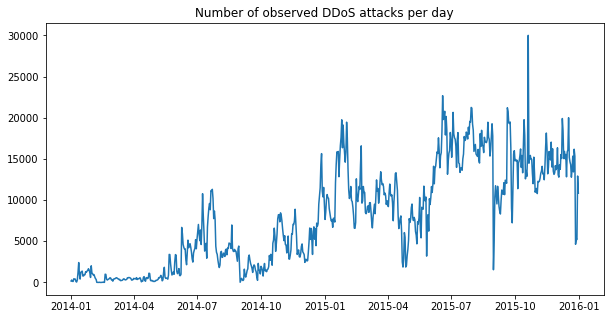

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.date.value_counts().sort_index())
ax.set_title("Number of observed DDoS attacks per day")

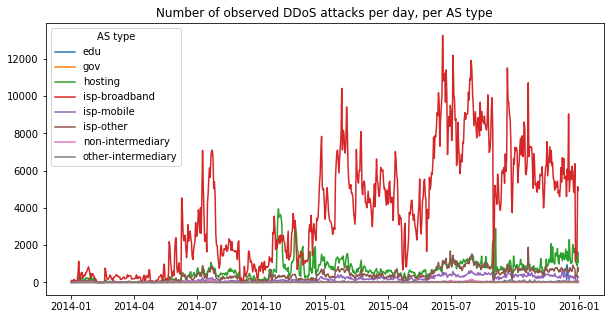

In [48]:
# number of attacks per day, per AS type

nrAttacksPerASType = (df[["as_type", "date"]].groupby("date")
                                             .as_type.value_counts()
                                             .unstack().fillna(0))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(nrAttacksPerASType)
ax.set_title("Number of observed DDoS attacks per day, per AS type")
ax.legend(nrAttacksPerASType.columns.tolist(), title="AS type")

In [6]:
# AS victims, ISP broadband & hosting

asesHosting = df.loc[df["as_type"] == "hosting"]
asesIspBroadband = df.loc[df["as_type"] == "isp-broadband"]

In [11]:
asesHostingNrAttacks = asesHosting.org.value_counts()

In [12]:
# top ten hosting providers under most attacks 
asesHostingNrAttacks[:10]

OVH SAS                        141335
OVH Hosting                     75347
NSS S.A.                        52311
Hetzner Online AG               16082
Amazon.com                      13511
Iliad Hosting                    9436
Limestone Networks               9157
Server Block                     8351
Iliad Entreprises Customers      8047
SingleHop                        6685
Name: org, dtype: int64

In [30]:
(asesHosting.loc[asesHosting.org == "Amazon.com"]
            .loc[asesHosting.as_ipsize_seen == 748413.0]
            [["org", "as_ipsize_seen", "raw_as"]]
            .drop_duplicates())


,org,as_ipsize_seen,raw_as
26826,Amazon.com,748413.0,AS14618 Amazon.com<comma> Inc.
603138,Amazon.com,748413.0,None


In [18]:
(asesHosting.loc[asesHosting.org.isin(asesHostingNrAttacks.index.tolist()[:10])]
                [["org", "as_ipsize_seen", "as_domainsize_seen", "org_tag"]].drop_duplicates())

,org,as_ipsize_seen,as_domainsize_seen,org_tag
26826,Amazon.com,748413.0,4203490.0,hosting
29630,SingleHop,90415.0,1075450.0,NaN
122940,Server Block,391410.0,4552561.0,NaN
130919,OVH Hosting,599916.0,5984318.0,hosting
133303,Hetzner Online AG,391410.0,4552561.0,hosting
159598,Limestone Networks,26579.0,423832.0,hosting
201647,OVH SAS,599916.0,5984318.0,hosting
204968,Amazon.com,908402.0,3610604.0,hosting
289962,NSS S.A.,7637.0,56244.0,NaN
374840,Iliad Entreprises Customers,84462.0,512173.0,hosting


In [24]:
(asesHosting.loc[asesHosting.org == "Amazon.com"]
                [["org", "as_ipsize_seen", "as_domainsize_seen", "org_tag", "raw_as", "raw_hostname"]].drop_duplicates())

,org,as_ipsize_seen,as_domainsize_seen,org_tag,raw_as,raw_hostname
26826,Amazon.com,748413.0,4203490.0,hosting,AS14618 Amazon.com<comma> Inc.,ec2-107-20-132-229.compute-1.amazonaws.com
26834,Amazon.com,748413.0,4203490.0,hosting,AS14618 Amazon.com<comma> Inc.,ec2-107-20-136-161.compute-1.amazonaws.com
26845,Amazon.com,748413.0,4203490.0,hosting,AS14618 Amazon.com<comma> Inc.,ec2-107-20-138-179.compute-1.amazonaws.com
26846,Amazon.com,748413.0,4203490.0,hosting,AS14618 Amazon.com<comma> Inc.,ec2-107-20-159-20.compute-1.amazonaws.com
26850,Amazon.com,748413.0,4203490.0,hosting,AS14618 Amazon.com<comma> Inc.,ec2-107-20-160-121.compute-1.amazonaws.com
26851,Amazon.com,748413.0,4203490.0,hosting,AS14618 Amazon.com<comma> Inc.,ec2-107-20-165-199.compute-1.amazonaws.com
26852,Amazon.com,748413.0,4203490.0,hosting,AS14618 Amazon.com<comma> Inc.,ec2-107-20-170-232.compute-1.amazonaws.com
26855,Amazon.com,748413.0,4203490.0,hosting,AS14618 Amazon.com<comma> Inc.,ec2-107-20-176-212.compute-1.amazonaws.com
26860,Amazon.com,748413.0,4203490.0,hosting,AS14618 Amazon.com<comma> Inc.,ec2-107-20-179-106.compute-1.amazonaws.com
26865,Amazon.com,748413.0,4203490.0,hosting,AS14618 Amazon.com<comma> Inc.,ec2-107-20-180-38.compute-1.amazonaws.com


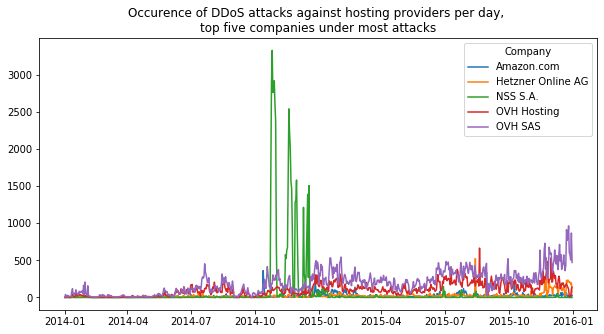

In [13]:
# number of attacks against hosting providers per day, per org

nrAttacksHostingPerOrg = (asesHosting.loc[asesHosting.org.isin(asesHostingNrAttacks.index.tolist()[:5])]
                                         [["org", "date"]]
                                     .groupby("date")
                                     .org.value_counts()
                                     .unstack()
                                     .fillna(0))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(nrAttacksHostingPerOrg)
ax.set_title("Occurence of DDoS attacks against hosting providers per day, \ntop five companies under most attacks")
# ax.set_yscale('log')
ax.legend(nrAttacksHostingPerOrg.columns.tolist(), title="Company")
ax.figure.savefig("images/nrAttacksHostingTopFiveOrgs.png")

In [82]:
asesRawAsAmazon = asesHosting.loc[asesHosting.raw_as.str.contains("Amazon")]

asesRawAsAmazon.loc[asesRawAsAmazon.org == "Facebook"].iloc[0]

target_ip                                                     54.83.222.105
date                                                    2015-11-19 00:00:00
sensor_id                                                         sensor005
service                                                                 dns
start_time                                              2015-11-19 12:10:38
stop_time                                               2015-11-19 12:13:55
duration                                                                197
packets                                                                 993
raw_country                                                   United States
raw_as                                       AS14618 Amazon.com<comma> Inc.
raw_hostname                      ec2-54-83-222-105.compute-1.amazonaws.com
udp_port_list                                                      [137298]
pyasn_as                                                              14618
pyasn_as_bgp